In [1]:
import re

import pandas as pd
import sqlalchemy as sa
import numpy as np
import seaborn as sns
sns.set_theme(context='notebook', style='whitegrid')

import tsfeatures
import forecast_tools

import itertools

from matplotlib import pyplot as plt

C:\Users\christopher.sampson\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
engine = sa.create_engine(open("SQL_queries/engine.txt", 'r').read())

# Num Referrals Processing

In [3]:
with engine.connect() as conn:
    refs_df = pd.read_sql(open("SQL_queries/referrals_general_surgery.sql").read(), con=conn.connection)

<Axes: xlabel='Urgency'>

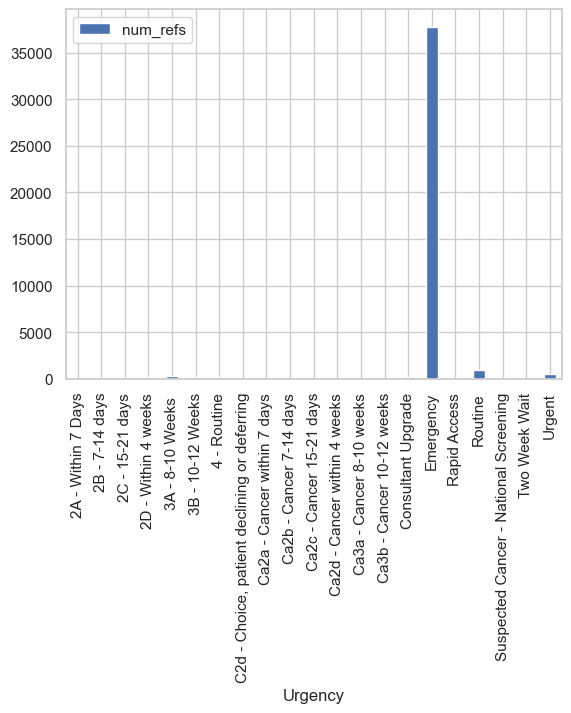

In [4]:
refs_df[["Urgency", "num_refs"]].groupby("Urgency").sum().plot.bar()

<Axes: xlabel='Urgency'>

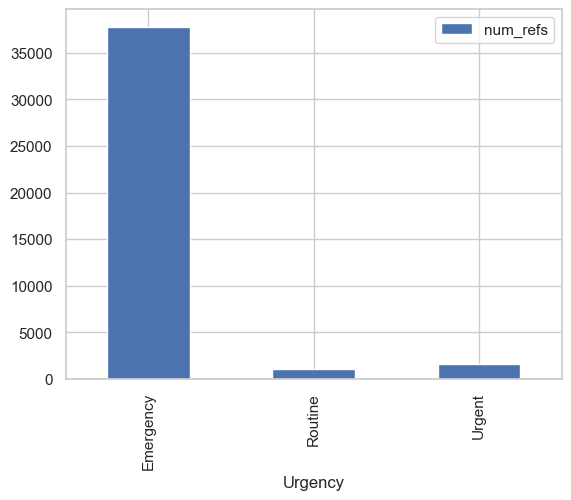

In [5]:
# coarse mapping
routine_pattern = re.compile(r'.*Routine.*')

refs_df.loc[refs_df["Urgency"].apply(lambda r: True if routine_pattern.match(r) else False), "Urgency"] = "Routine"
refs_df.loc[(refs_df["Urgency"] != "Routine") & (refs_df["Urgency"] != "Emergency"), "Urgency"] = "Urgent"

refs_df[["Urgency", "num_refs"]].groupby("Urgency").sum().plot.bar()

<Axes: xlabel='RefRecDate'>

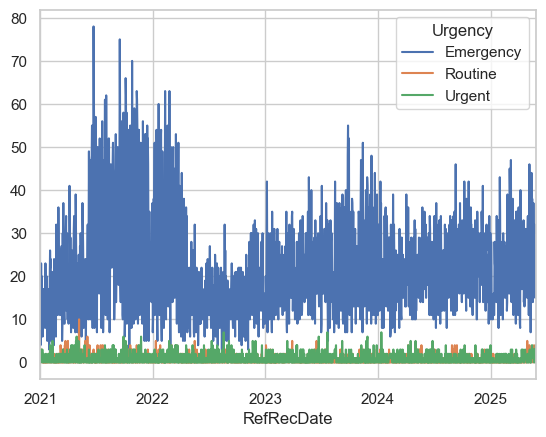

In [6]:
refs_df = refs_df.groupby(["RefRecDate", "Urgency"]).sum().reset_index()
refs_df.pivot(index="RefRecDate", columns="Urgency", values="num_refs").fillna(0).plot()

<Axes: xlabel='RefRecDate'>

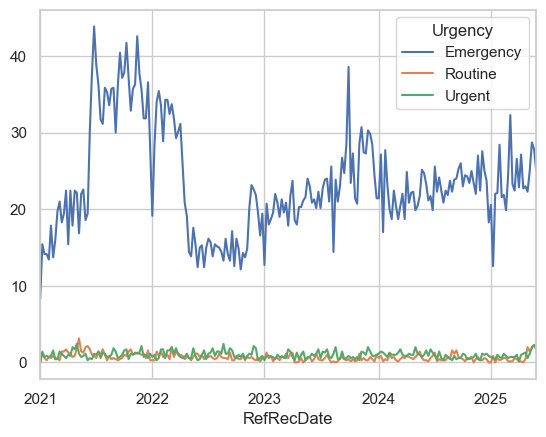

In [7]:
refs_df.pivot(index="RefRecDate", columns="Urgency", values="num_refs").fillna(0).resample('W').mean().plot()

<Axes: xlabel='RefRecDate'>

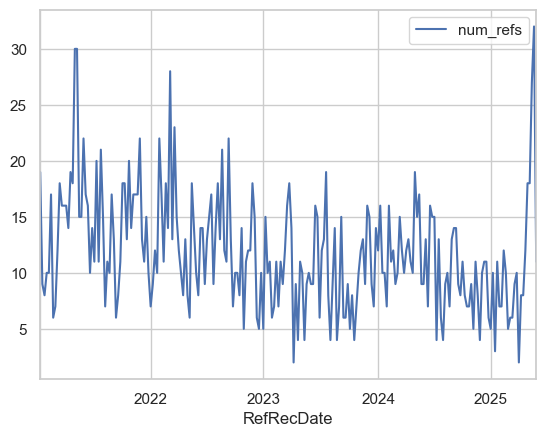

In [8]:
# Elective(?) 
refs_df[refs_df["Urgency"] != "Emergency"].groupby("RefRecDate").sum().resample('W').sum().plot()

<Axes: xlabel='RefRecDate'>

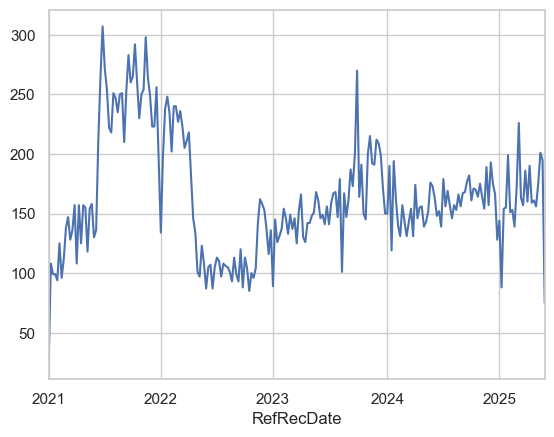

In [9]:
refs_df[refs_df["Urgency"] == "Emergency"].set_index("RefRecDate").resample("W")["num_refs"].sum().plot()

# Time between refs and appts

In [10]:
with engine.connect() as conn:
    refs_time_df = pd.read_sql(open("SQL_queries/length_of_time_between_referrals_and_appt_general_surgery.sql").read(), con=conn.connection) 

In [11]:
refs_time_df.loc[refs_time_df["Urgency"].apply(lambda r: True if routine_pattern.match(r) else False), "Urgency"] = "Routine"
refs_time_df.loc[(refs_time_df["Urgency"] != "Routine") & (refs_time_df["Urgency"] != "Emergency"), "Urgency"] = "Urgent"

<Axes: ylabel='Frequency'>

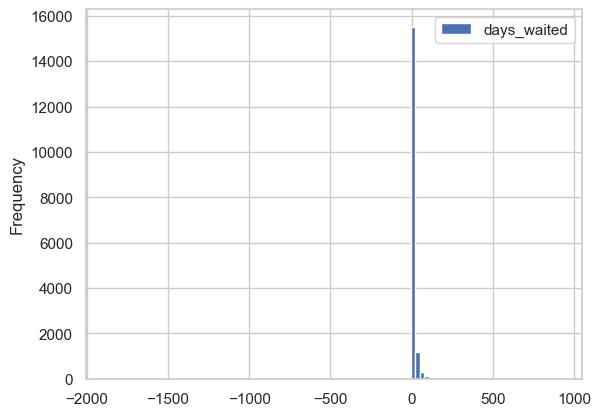

In [12]:
refs_time_df[refs_time_df["Urgency"] == "Emergency"].plot.hist(bins=100)

# Calculate the inter-arrival time in hours
# Look at time profiles (busy periods and quiet periods)


<Axes: ylabel='Frequency'>

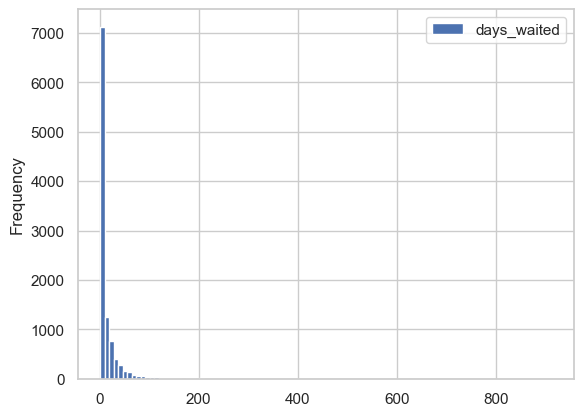

In [13]:
# TODO: Investigate the negative days waited
refs_time_df[(refs_time_df["Urgency"] == "Emergency") & (refs_time_df["days_waited"] > 0)].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

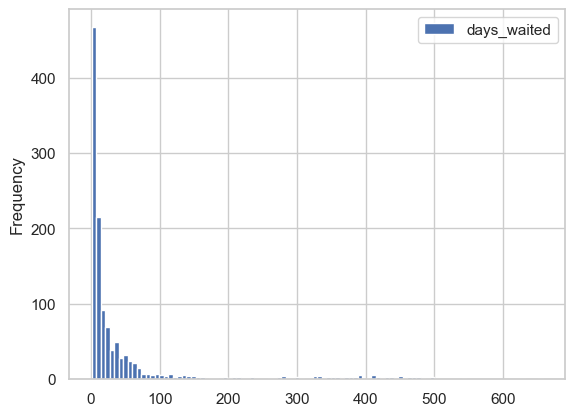

In [14]:
refs_time_df[(refs_time_df["Urgency"] == "Urgent") & (refs_time_df["days_waited"] > 0)].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

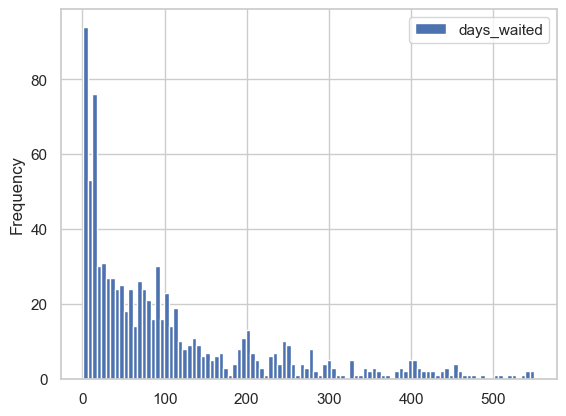

In [15]:
refs_time_df[(refs_time_df["Urgency"] == "Routine") & (refs_time_df["days_waited"] > 0)].plot.hist(bins=100)

## Analyst Elective

In [16]:
with engine.connect() as conn:
    elective_df = pd.read_sql(sql = open("SQL_queries/surgical_aditions_detailed.sql").read(), con=conn.connection)

elective_df.DateOnList = pd.to_datetime(elective_df.DateOnList)
elective_df = elective_df.set_index('DateOnList')

<Axes: xlabel='DateOnList'>

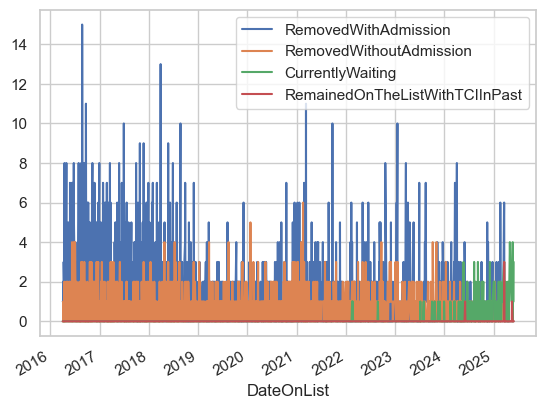

In [17]:
gen_surg_df = elective_df.query('TreatmentFunctionCode=="100"')
cols = ['RemovedWithAdmission', 'RemovedWithoutAdmission', 'CurrentlyWaiting', 'RemainedOnTheListWithTCIInPast']

gen_surg_df[cols].plot()

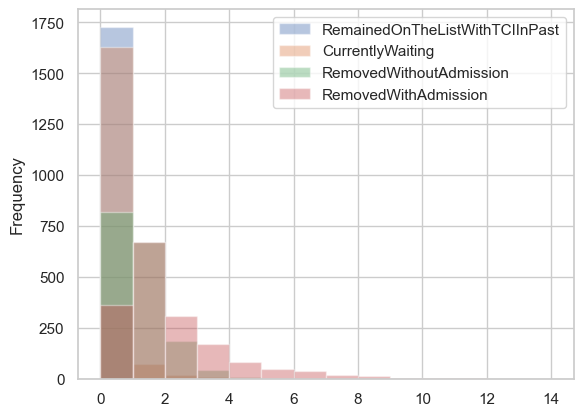

In [18]:
for col in cols[::-1]:
    gen_surg_df[col].plot.hist(alpha=0.4, label=col, bins=[*range(15)])

plt.legend()

In [19]:
gen_surg_df = gen_surg_df[cols].resample('d').sum()
gen_surg_df

,RemovedWithAdmission,RemovedWithoutAdmission,CurrentlyWaiting,RemainedOnTheListWithTCIInPast
DateOnList,,,,
2016-04-01,1,0,0,0
2016-04-02,0,0,0,0
2016-04-03,0,0,0,0
2016-04-04,1,0,0,0
2016-04-05,2,1,0,0
...,...,...,...,...
2025-05-24,0,0,0,0
2025-05-25,0,0,0,0
2025-05-26,0,0,0,0


We have appointments still on the books, so the number of people who will be removed without admission requires consideration:

In [20]:
tmp_df = gen_surg_df.query("CurrentlyWaiting == 0")

frac_removed_wout_admission = (tmp_df["RemovedWithoutAdmission"] / (tmp_df["RemovedWithAdmission"] + tmp_df["RemovedWithoutAdmission"])).dropna().mean()
frac_removed_wout_admission

0.3297245437073341

Checking that this number is representative, and not biased by old data

<Figure size 640x480 with 0 Axes>

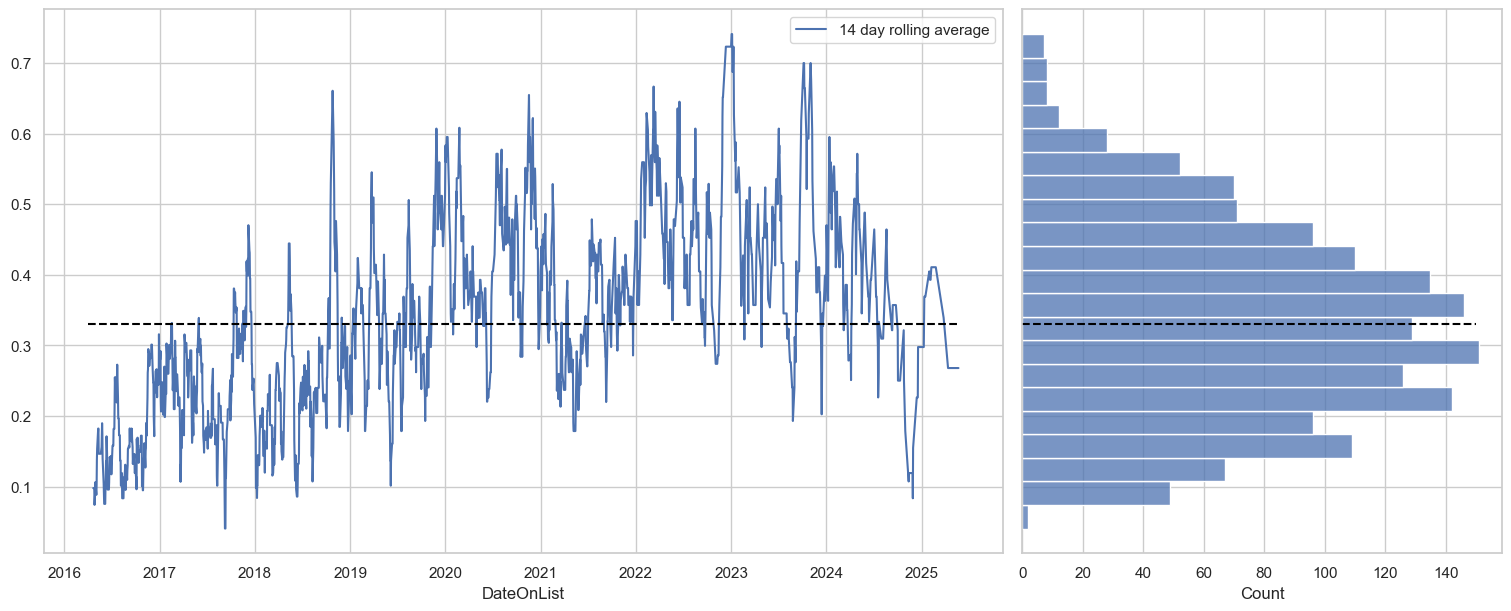

In [21]:
plt.tight_layout()

fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]}, sharey=True, constrained_layout=True)
fig.set_figwidth(15)
fig.set_figheight(6)

tmp_df = gen_surg_df.query("CurrentlyWaiting == 0")
removed_ratio = (tmp_df["RemovedWithoutAdmission"] / (tmp_df["RemovedWithAdmission"] + tmp_df["RemovedWithoutAdmission"])).dropna().rolling(14).mean()

sns.lineplot(removed_ratio, ax=ax[0], label='14 day rolling average')
ax[0].hlines(frac_removed_wout_admission, tmp_df.index.min(), tmp_df.index.max(), color='black', linestyles='dashed')

sns.histplot(y=removed_ratio.dropna().values, ax=ax[1], label='14 day rolling average')
ax[1].hlines(frac_removed_wout_admission, 0, 150, color='black', linestyles='dashed')

Seems like a sensible value based on the values in 2022 onwards with the recent drop

In [22]:
gen_surg_df["RemainedOnTheListWithTCIInPast"].sum() # Going to ignore this as a DQ issue

5

In [23]:
num_dates_with_current_waiters = len(gen_surg_df.query('CurrentlyWaiting != 0'))
num_dates_with_current_waiters

104

In [24]:
tmp_df = gen_surg_df.query('CurrentlyWaiting != 0')["CurrentlyWaiting"]

dates_to_select = tmp_df.index.repeat(tmp_df.values)
num_dates_to_choose = round(len(dates_to_select)*(1-frac_removed_wout_admission))

selected_dates = pd.Series(np.random.choice(dates_to_select, num_dates_to_choose, replace=False)).value_counts()
selected_dates

2024-09-05    3
2025-04-30    3
2025-05-28    3
2025-03-20    2
2024-10-08    2
             ..
2024-11-01    1
2024-06-25    1
2025-02-28    1
2024-12-11    1
2024-11-19    1
Name: count, Length: 77, dtype: int64

In [25]:
processed_df = pd.merge(gen_surg_df, selected_dates, left_index=True, right_index=True, how='left').fillna(0)

processed_df["count"] = processed_df["count"].astype(int)
processed_df["RemovedWithAdmission"] += processed_df["count"]
processed_df

,RemovedWithAdmission,RemovedWithoutAdmission,CurrentlyWaiting,RemainedOnTheListWithTCIInPast,count
DateOnList,,,,,
2016-04-01,1,0,0,0,0
2016-04-02,0,0,0,0,0
2016-04-03,0,0,0,0,0
2016-04-04,1,0,0,0,0
2016-04-05,2,1,0,0,0
...,...,...,...,...,...
2025-05-24,0,0,0,0,0
2025-05-25,0,0,0,0,0
2025-05-26,0,0,0,0,0


<Axes: xlabel='DateOnList'>

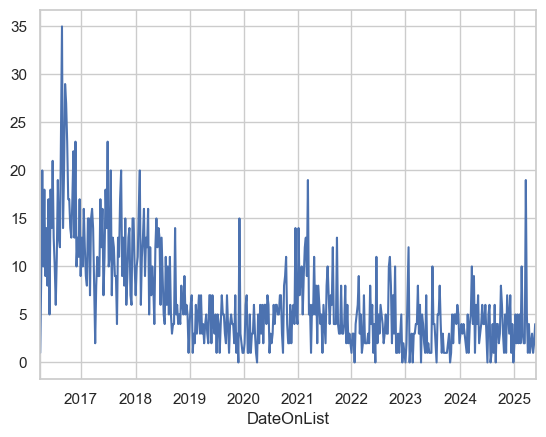

In [26]:
combined_df = processed_df["RemovedWithAdmission"].resample('W').sum()

combined_df.plot()

<Axes: xlabel='DateOnList'>

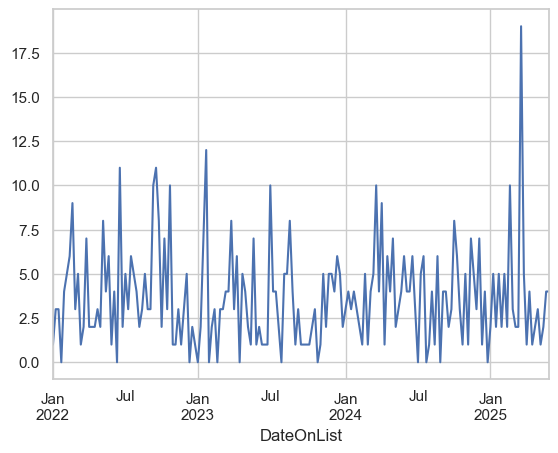

In [27]:
# 2022 onwards to exclude COVID period
combined_df = combined_df[combined_df.index > '2022-01-01']
combined_df.plot()

### Entropy calculation

In [28]:
# spectral entropy (Shannon entropy) - closer to 1 means higher noise than signal...
tsfeatures.entropy(combined_df) 

{'entropy': 0.8733579056397401}

### Forecasting models

<Axes: xlabel='DateOnList', ylabel='RemovedWithAdmission'>

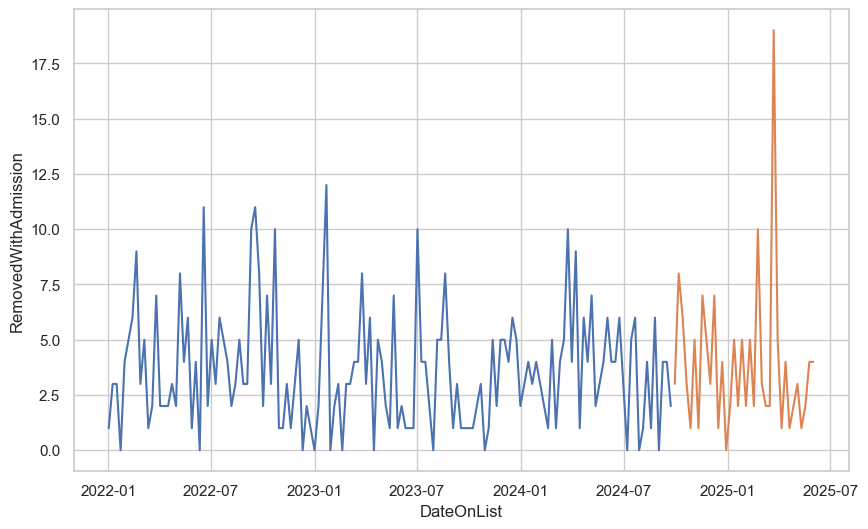

In [29]:
train_test_split_val = round(len(combined_df)* 0.8)
train_df = combined_df[:train_test_split_val]
test_df = combined_df[train_test_split_val:]

plt.figure(figsize=(10,6))

sns.lineplot(train_df)
sns.lineplot(test_df)

#### Naive Forecasts

In [30]:
from forecast_tools.baseline import Average, Naive1, SNaive
from forecast_tools.metrics import forecast_errors, winkler_score
from mapie.regression import MapieTimeSeriesRegressor
from mapie.metrics import regression_coverage_score


from sklearn.base import BaseEstimator


In [31]:
class FTWrapper(BaseEstimator):
    def __init__(self, model):
        self.model = model
        super().__init__()

    def fit(self, X, y):
        self.is_fitted_ = True
        self.model.fit(pd.DataFrame(index=X, data=y))
        return self
    
    def predict(self, df):
        return self.model.predict(horizon=len(df))
        

In [32]:
def fit_model(model, test_df, train_df):
    model = FTWrapper(model)
    mapie = MapieTimeSeriesRegressor(model, method='enbpi')

    mapie.fit(train_df.index, train_df.values)
    preds, pi = mapie.predict(test_df, alpha=0.1)


    model.fit(train_df.index, train_df.values)
    lb, ub, median = calculate_sample_paths(model.predict(train_df.index), test_df, train_df)
    sp_pis = np.hstack([lb.reshape(-1, 1), ub.reshape(-1,1)])


    plt.figure(figsize=(10,6))
    sns.lineplot(train_df)
    sns.lineplot(test_df)
    sns.lineplot(x=test_df.index, y=preds)

    plt.fill_between(test_df.index, pi[:,0].reshape(-1), pi[:,1].reshape(-1), alpha=0.3, label="90% Conformal Interval", color='g')

    plt.fill_between(test_df.index, lb, ub, alpha=0.3, label="90% sample path Interval", color='y')

    plt.legend()

    
    # Coverage
    scores = {
        "Conformal Coverage": regression_coverage_score(test_df.values, pi[:, 0], pi[:, 1]),
        "Sample Paths Coverage": regression_coverage_score(test_df.values, lb, ub),
        "Conformal Winkler Score": winkler_score(test_df.values, pi[:, :, 0], 0.1),
        "Sample Paths Winkler Score": winkler_score(test_df.values, sp_pis, 0.1),
    }
    scores.update(forecast_errors(y_true=test_df.values, y_pred=preds, metrics=['me','mae','mse','rmse']))
    print(scores)

    return scores


def calculate_sample_paths(fitted_vals, test_df, train_df):

    resid_stddev = np.std(fitted_vals - train_df.values)

    n_paths = 100
    sample_paths = np.random.normal(0, resid_stddev, size=(n_paths, len(test_df))).cumsum(axis=1)

    lb = np.percentile(sample_paths, 5, axis=0)
    ub = np.percentile(sample_paths, 95, axis=0)
    median = np.median(sample_paths, axis=0)

    return lb, ub, median

{'Conformal Coverage': 0.9444444444444444, 'Sample Paths Coverage': 0.9444444444444444, 'Conformal Winkler Score': 15.086995164340705, 'Sample Paths Winkler Score': 37.334631063505455, 'me': 0.28049728049728057, 'mae': 2.234265734265734, 'mse': 11.51077748979847, 'rmse': 3.3927536736106365}


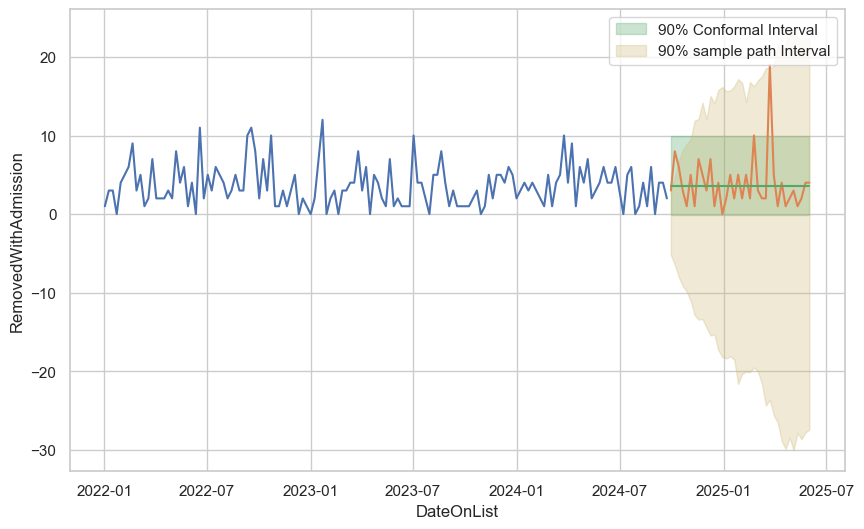

In [33]:
av_scores = fit_model(Average(), test_df, train_df)

{'Conformal Coverage': 0.9166666666666666, 'Sample Paths Coverage': 0.9444444444444444, 'Conformal Winkler Score': 14.893550893550891, 'Sample Paths Winkler Score': 35.738435989034265, 'me': 1.8888888888888888, 'mae': 2.3333333333333335, 'mse': 15.0, 'rmse': 3.872983346207417}


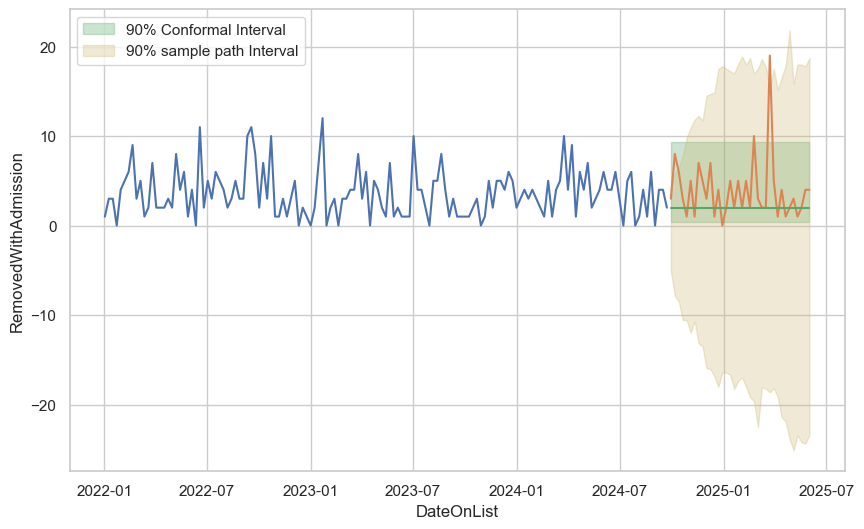

In [34]:
nv_scores = fit_model(Naive1(), test_df, train_df)

{'Conformal Coverage': 0.9444444444444444, 'Sample Paths Coverage': 0.9722222222222222, 'Conformal Winkler Score': 17.586635586635584, 'Sample Paths Winkler Score': 40.125997527921214, 'me': 0.19444444444444445, 'mae': 2.6944444444444446, 'mse': 12.027777777777779, 'rmse': 3.4681086744474685}


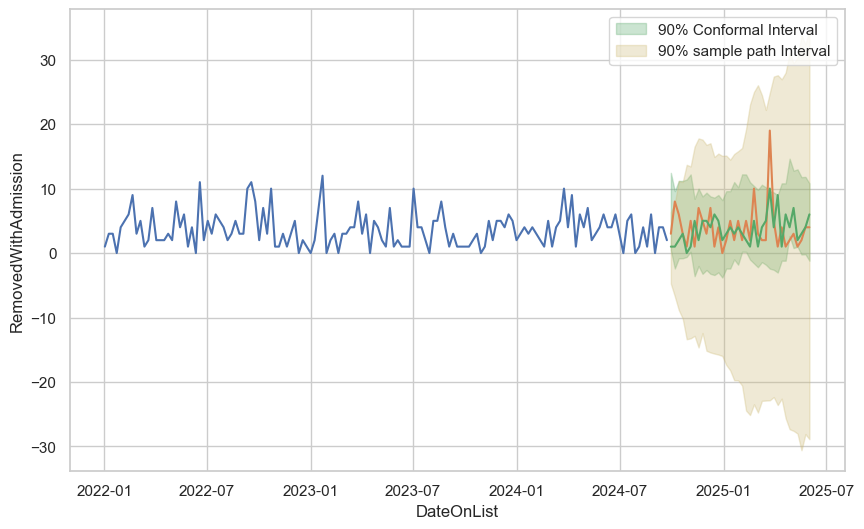

In [35]:
snv_scores = fit_model(SNaive(period=52), test_df, train_df)

#### Stats Forecasts

In [36]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, AutoETS, AutoTheta, AutoCES
from statsforecast.utils import ConformalIntervals

In [37]:
tmp_df = train_df.to_frame().reset_index(names="ds")
tmp_df.rename({"RemovedWithAdmission":"y"}, axis=1, inplace=True)
tmp_df["unique_id"] = 1
tmp_df

season_length = 52 
horizon = len(test_df) 

conformal_range = 90


models = [
    AutoARIMA(season_length=season_length),
    AutoETS(season_length=season_length), 
    AutoTheta(season_length=season_length),
    AutoCES(season_length=season_length), 
]

fcst = StatsForecast(
    models=models, 
    freq='W',
    n_jobs=-1
)

preds = fcst.forecast(df=tmp_df, h=horizon, prediction_intervals=ConformalIntervals(h=horizon, n_windows=2), level=[conformal_range], fitted=True)

fitted_vals = fcst.forecast_fitted_values()

In [38]:
preds = preds.set_index('ds')
fitted_vals = fitted_vals.set_index('ds')

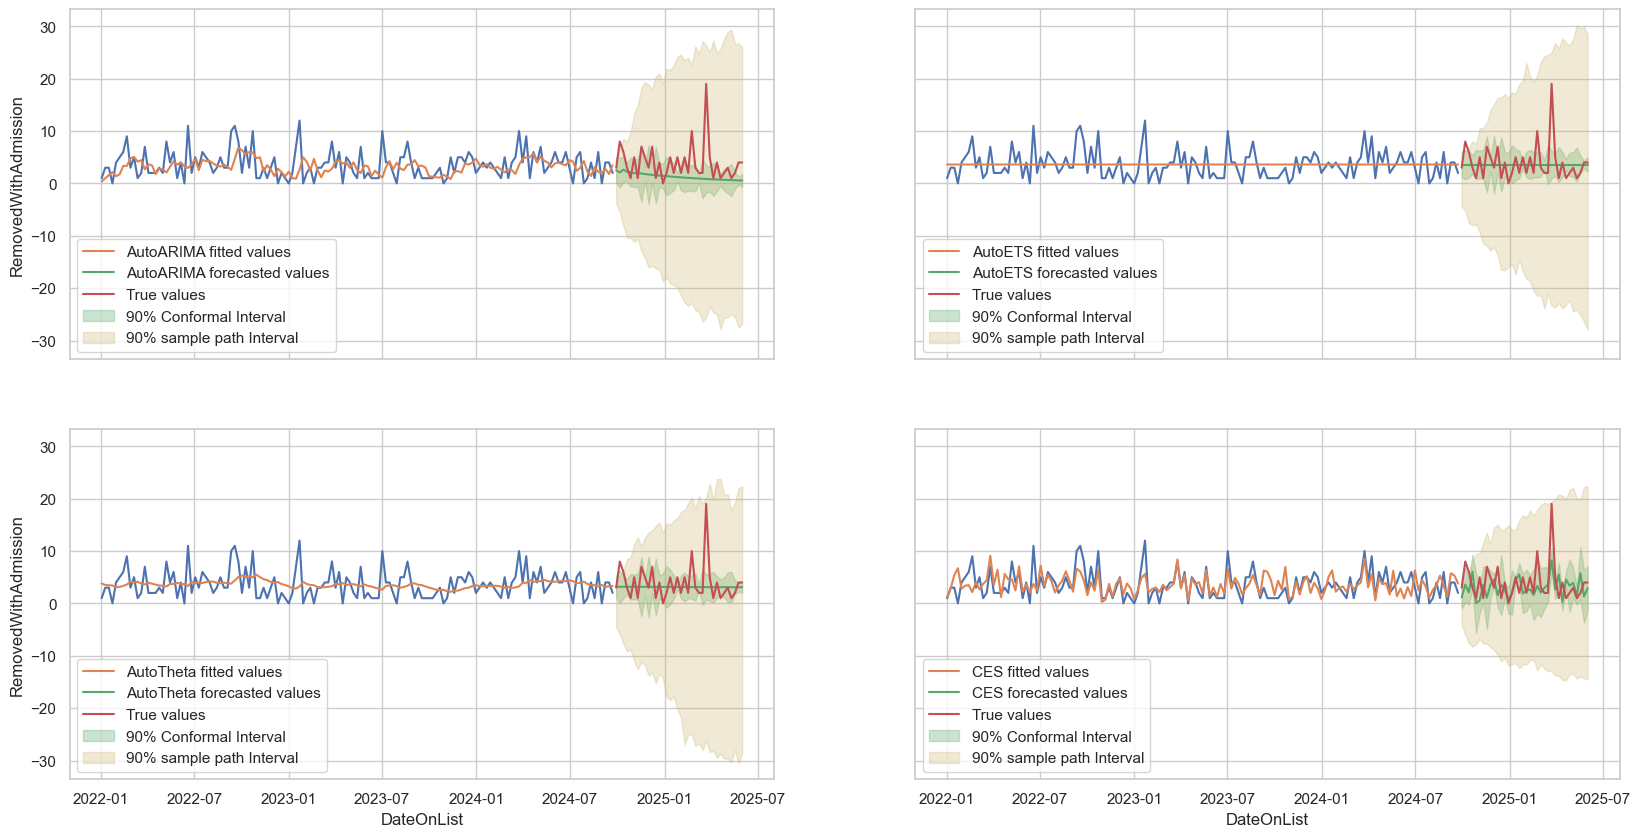

In [39]:
scores = {}

model_labels = preds.columns[~preds.columns.str.match(r'.*(lo|hi).*')]

nrows = round(len(model_labels) / 2)

fig, ax = plt.subplots(nrows, ncols=2, sharex=True, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(20)

for a, col in zip(itertools.chain(*ax), model_labels):
    sns.lineplot(train_df, ax=a)
    sns.lineplot(fitted_vals[col], ax=a, label=f'{col} fitted values')
    sns.lineplot(preds[col], ax=a, label=f'{col} forecasted values')
    sns.lineplot(test_df, ax=a, label="True values")

    lb, ub, median = calculate_sample_paths(fitted_vals[col], test_df, train_df)
    sp_pis = np.hstack([lb.reshape(-1, 1), ub.reshape(-1,1)])

    a.fill_between(preds.index, preds[f"{col}-lo-{conformal_range}"], preds[f"{col}-hi-{conformal_range}"], alpha=0.3, label=f"{conformal_range}% Conformal Interval", color='g')
    a.fill_between(preds.index, lb, ub, alpha=0.3, label="90% sample path Interval", color='y')

    a.legend()

    scores[col] = {
        "Conformal Coverage": regression_coverage_score(test_df.values, preds[f"{col}-lo-{conformal_range}"], preds[f"{col}-hi-{conformal_range}"]),
        "Sample Paths Coverage": regression_coverage_score(test_df.values, lb, ub),
        "Conformal Winkler Score": winkler_score(test_df.values, preds[[f"{col}-lo-{conformal_range}", f"{col}-hi-{conformal_range}"]], 0.1),
        "Sample Paths Winkler Score": winkler_score(test_df.values, sp_pis, 0.1),
    }

    scores[col].update(forecast_errors(y_true=test_df.values, y_pred=preds[col], metrics=['me','mae','mse','rmse']))

In [40]:
scores["Average"] = av_scores
scores["Naive"] = nv_scores
scores["Seasonal Naive"] = snv_scores

In [41]:
pd.DataFrame(scores)

,AutoARIMA,AutoETS,AutoTheta,CES,Average,Naive,Seasonal Naive
Conformal Coverage,0.555556,0.722222,0.694444,0.666667,0.944444,0.916667,0.944444
Sample Paths Coverage,0.972222,0.972222,0.972222,0.972222,0.944444,0.944444,0.972222
Conformal Winkler Score,30.169966,18.746563,19.853092,21.400475,15.086995,14.893551,17.586636
Sample Paths Winkler Score,41.138073,38.043537,37.666624,28.589589,37.334631,35.738436,40.125998
me,2.581931,0.277865,0.751579,0.904940,0.280497,1.888889,0.194444
mae,2.809704,2.234558,2.179487,2.664014,2.234266,2.333333,2.694444
mse,18.244606,11.509307,11.984896,11.782320,11.510777,15.000000,12.027778
rmse,4.271370,3.392537,3.461921,3.432538,3.392754,3.872983,3.468109


#### ML Forecasts

In [42]:
# TODO:
# - Explore seasonality first, either empirically or with a decomposable model
# - Are there any months that are special events
# - Box plots weeks/days/months

# - Look at top 5 for gen surg, then apply those to other TFCs, maybe combine models for different times of year etc..
# - KEEP IT SIMPLE!
# - Have a look at log transformations (to avoid 0 predictions etc..)


# - check if all these models can handle 0s in the forecast -- they can't (CES)
# - tidy up the code
# - apply to mlforecast too

# - get the emergency data and apply it to that too